In [1]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import enum
import typing


In [2]:
class Dir(enum.Enum):
    North = enum.auto()
    East = enum.auto()
    South = enum.auto()
    West = enum.auto()

    def rev(self):
        match self:
            case Dir.North: return Dir.South
            case Dir.South: return Dir.North
            case Dir.East: return Dir.West
            case Dir.West: return Dir.East
            

@dataclass
class Tile:
    x : int
    y : int
    c : str
    ways : typing.Dict
    loop : bool = False

    @classmethod
    def frommap(cls,x,y,c):
        match c:
            case "|": dirs = {Dir.South:Dir.North}
            case "-": dirs = {Dir.East:Dir.West}
            case "L": dirs = {Dir.East:Dir.North}
            case "J": dirs = {Dir.North:Dir.West}
            case "7": dirs = {Dir.South:Dir.West}
            case "F": dirs = {Dir.South:Dir.East}
            case _: dirs={}
        _dirs = dirs.copy()
        for k,v in dirs.items():
            _dirs[v] = k
        return cls(x,y,c,_dirs,c=="S")
    
@dataclass
class TileCrawler:
    x : int
    y : int
    dir : Dir
    distance: int = 0

    def move(self,pipemap):
        match self.dir:
            case Dir.North: self.y -= 1 #We keep the North at the top of the map but the y-axis point downward
            case Dir.South: self.y += 1
            case Dir.East: self.x += 1
            case Dir.West: self.x -= 1
        self.dir = pipemap[self.y][self.x].ways[self.dir.rev()]
        self.distance += 1

    def movetostart(self,pipemap,flagloop=True):
        self.move(pipemap)
        while not pipemap[self.y][self.x].loop:
             if flagloop: pipemap[self.y][self.x].loop =True
             self.move(pipemap)
        return self.distance//2
    
    @classmethod
    def spawnatstart(cls,pipemap):
        for y in range(len(pipemap)):
            for x,t in enumerate(pipemap[y]):
                if t.loop:
                    ways = []
                    for d in Dir:
                        try:
                            match d:
                                case Dir.North:
                                    if d.rev() in pipemap[t.y-1][t.x].ways.keys(): ways.append(d)
                                case Dir.South: 
                                    if d.rev() in pipemap[t.y+1][t.x].ways.keys(): ways.append(d)
                                case Dir.East: 
                                    if d.rev() in pipemap[t.y][t.x+1].ways.keys(): ways.append(d)
                                case Dir.West:
                                    if d.rev() in pipemap[t.y][t.x-1].ways.keys(): ways.append(d)
                        except IndexError: pass
                    a,b = ways
                    t.ways[a] = b
                    t.ways[b] = a
                    return cls(t.x,t.y,a)
                



In [3]:
with open("input10.txt") as f:
    pipemap = [[Tile.frommap(x,y,c) for x,c in enumerate(line)] for y,line in enumerate(f.read().splitlines())]
crawler = TileCrawler.spawnatstart(pipemap)

# Part 1

In [4]:
crawler.movetostart(pipemap,flagloop=True)

6812

# Part 2

In [5]:
with open("input10.txt") as f:
    pipemap = [[Tile.frommap(x,y,c) for x,c in enumerate(line)] for y,line in enumerate(f.read().splitlines())]

def findinside(pipemap):
    crawler = TileCrawler.spawnatstart(pipemap)
    loop = np.zeros((len(pipemap),len(pipemap[0])),dtype=int)
    inside = np.zeros((len(pipemap),len(pipemap[0])),dtype=int)
    verticalwalls = {"|","F","7"}
    for d in pipemap[crawler.y][crawler.y].ways.keys():
        if d ==Dir.South: verticalwalls.add("S")
    #Flagging the loop
    crawler.movetostart(pipemap,flagloop=True)
    for y,line in enumerate(pipemap):
        parity= 0
        for x,t in enumerate(line):
            if t.loop:
                loop[y,x] = 1
                if t.c in verticalwalls:
                    parity = (parity+1)%2 
            else:
                inside[y,x] = parity
    return inside,loop

In [6]:
inside,loop =findinside(pipemap)

In [7]:
inside.sum()

527

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

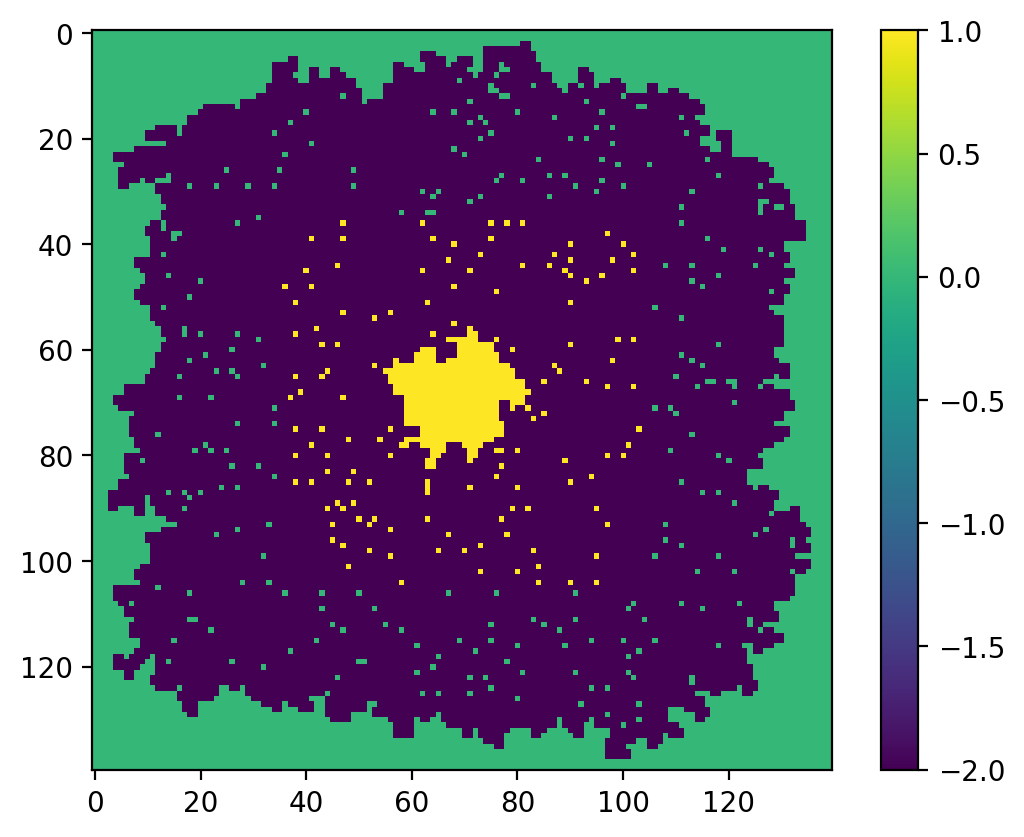

In [9]:
plt.imshow(inside-2*loop)
plt.colorbar()